# Lab 1 – ROI & Mask Refinement

In this lab, we practice the first two steps in the project's lane following pipeline:

1. Apply ROI (Region of Interest) to retain only the road surface area in front of the vehicle.

2. Filter noise and clean the lane mask (mask refinement) to obtain a continuous, clear lane area.  

> model generates lane mask → apply ROI → refine mask → BEV + scanline → controller.

#### Why are ROI & mask refinement needed?
- The segmentation model often predicts areas outside the road surface as well (noise, reflections, shadows…).
- If we use this raw mask to calculate geometry (centerline, curvature, heading), the controller will:   
    - Jump erratically to the noise region,    
    - Steer jerkily,   
    - Cause the car to become unstable.

Therefore, before reaching the geometry step, we always need to:

1. Limit the region of interest (ROI) to the road surface area.

2. Clean the mask so that only a clear, continuous lane region remains.

### 1. Environment Setup
In this lab we will use OpenCV (`cv2`) and NumPy. Run the following cell to import the required libraries.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### 2. Loading a Sample Mask
In practice, the binary lane mask comes from a neural network segmentation model. For this lab, you should prepare a sample binary mask image (values 0 or 1) and place it in the `data/` folder. The code below loads an image file into a NumPy array.

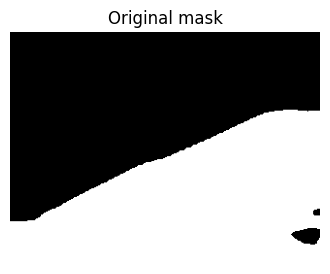

In [2]:
# TODO: provide the path to your sample mask image (grayscale PNG or JPG)
mask_path = r"D:\DATA\Test_datalab\frame_00250_1_mask_raw.png"  # e.g. 'data/lane_mask.png'

# Load the mask image as grayscale
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
if mask is None:
    raise FileNotFoundError('Mask file not found. Please place a binary mask image in the data/ folder.')

# Convert mask to binary 0/1
mask01 = (mask > 0).astype(np.uint8)

# Display the original mask
plt.figure(figsize=(4, 4))
plt.title('Original mask')
plt.imshow(mask01, cmap='gray')
plt.axis('off')
plt.show()

## Part 1 – Applying ROI (Region of Interest)

### 1. Intuition

The camera mounted on the AutoCar-Kit has a low viewing angle. In the image:

- The upper part is usually the ceiling, walls, people, table legs…
- The lower part is the road surface and lane markings.

For the lane-keeping task, we only need the region near the vehicle – meaning we only keep the bottom 40% polygon where the actual lane appears.
Instead of processing the entire image, we crop an ROI (Region of Interest):

> ROI = the polygon covering the road area that we care about.

In the main pipeline, ROI is defined using normalized coordinates (ratios) with respect to the image size, for example:

```python
roi_poly = np.float32([
    [0.03, 0.58],
    [0.97, 0.58],
    [0.97, 0.99],
    [0.03, 0.99],
])


### 2. Mathematical representation of ROI

Assume the output image of the segmentation model has size \(H \times W\).  
We denote:

- $M(x, y)$: the value of the lane mask at pixel $(x,y)$, trong đó $M(x,y) \in \{0,1\}$.
- $(x_i^{\text{ratio}},\, y_i^{\text{ratio}})$: the normalized coordinates of the ROI polygon vertices, each value belonging to $[0,1]$.

##### Converting normalized coordinates → pixel coordinates

To convert ROI points to actual pixel coordinates in the image, we multiply by the height and width:

$$
x_i^{\text{pix}}
= x_i^{\text{ratio}} \cdot W,
\qquad
y_i^{\text{pix}}
= y_i^{\text{ratio}} \cdot H.
$$

This ensures that the ROI remains independent of the image resolution and only changes according to the actual size $(W, H)$.


### 3. Constructing the ROI mask

We define the binary function $R(x,y)$ — the ROI mask — as follows:

$$
R(x,y) =
\begin{cases}
1, & \text{if } (x,y) \text{ lies inside the ROI polygon}, \\
0, & \text{if } (x,y) \text{ lies outside the ROI}.
\end{cases}
$$

This mask is created by filling the ROI polygon on a blank image.


### 4. Applying ROI to the lane mask

The mask after applying ROI is simply the pointwise multiplication between the original mask and the ROI mask:

$$
M_{\text{ROI}}(x,y)
= M(x,y) \cdot R(x,y).
$$

Meaning:

- If $(x,y)$ lies outside the ROI  
  ⇒ $R(x,y)=0$  
  ⇒ the pixel is removed.

- If $(x,y)$ lies inside the ROI  
  ⇒ $R(x,y)=1$  
  ⇒ the mask value is preserved.


### 5. Illustration

Applying ROI helps:

- Remove the entire upper part of the image (where the road does not exist).
- Reduce noise from objects, lighting, and human shadows.
- Make the downstream pipeline (refine mask → BEV → scanline → controller) more stable.

ROI acts as a spatial filter, keeping only what the vehicle truly cares about.


##### ROI Filterting 
![ROI Filtering](ROI.png)  

### 6. Practice – Applying ROI


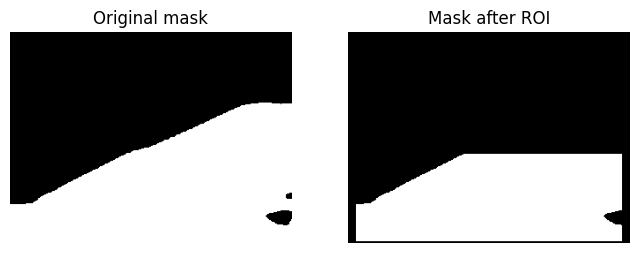

In [3]:
import numpy as np
import cv2

def apply_roi(mask01: np.ndarray, roi_poly: np.ndarray) -> np.ndarray:
    # Scale ROI polygon to pixel coordinates
    H, W = mask01.shape
    pts = (roi_poly * np.array([W, H], dtype=np.float32)).astype(np.int32)

    # Create a mask and fill the ROI polygon with ones
    roi_mask = np.zeros_like(mask01, dtype=np.uint8)
    cv2.fillPoly(roi_mask, [pts], 1)

    # Set pixels outside the ROI to zero
    mask_roi = mask01.copy()
    mask_roi[roi_mask == 0] = 0
    return mask_roi

# Define a default ROI polygon similar to the lane pipeline
roi_poly = np.float32([[0.03, 0.58], [0.97, 0.58], [0.97, 0.99], [0.03, 0.99]])
mask_roi = apply_roi(mask01, roi_poly)

# Display the result
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title('Original mask')
plt.imshow(mask01, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Mask after ROI')
plt.imshow(mask_roi, cmap='gray')
plt.axis('off')

plt.show()

## Part 2 – Mask Refinement

After applying ROI, the lane mask often contains many errors caused by the model prediction:

- The lane is broken (gaps),
- Small white dots appear (noise),
- There are many scattered regions that are not the actual lane.

The objective of the mask refinement step is:

> Transform the raw mask into a single lane region – clean – continuous – stable for the geometry step.

To achieve this, the pipeline performs 3 main operations:
1. Normalize the mask to binary form {0,1}
2. Apply morphological closing to connect broken lane segments
3. Keep only the region (contour) with the largest area
### 1. Normalizing the mask to binary form

In many cases, the model may output a mask with different values (0 or >0).  
We convert it to binary form:

$$
m(x,y) =
\begin{cases}
1, & \text{when } M(x,y) > 0, \\
0, & \text{otherwise}.
\end{cases}
$$

This ensures that the mask is always “clean” before performing morphological operations.
### 2. Morphological Closing – Connecting broken lane segments

#### Mathematical definition

The closing operation of a binary image \(m\) with kernel \(K\) is:

$$
m \bullet K = (m \oplus K) \ominus K
$$

Where:

- \(m \oplus K\): dilation – expanding the white region (connecting nearby points)
- \(m \ominus K\): erosion – shrinking the white region (removing expansion from dilation)

Intuitive meaning:

> Dilation fills small gaps → Erosion shrinks back → result preserves large structures but removes small holes.
#### Vertical kernel (5 × 25)

The pipeline uses the following kernel:

- Width 5 pixels → prevents two adjacent lanes from merging  
- Height 25 pixels → long enough to connect broken segments in the vertical direction (lane direction)

Kernel:

```python
ker_vertical = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 25))


##### Mask Refinement 
![Mask Refinement](mask_refinement.jpg)

### 3. Practice – Refine Mask

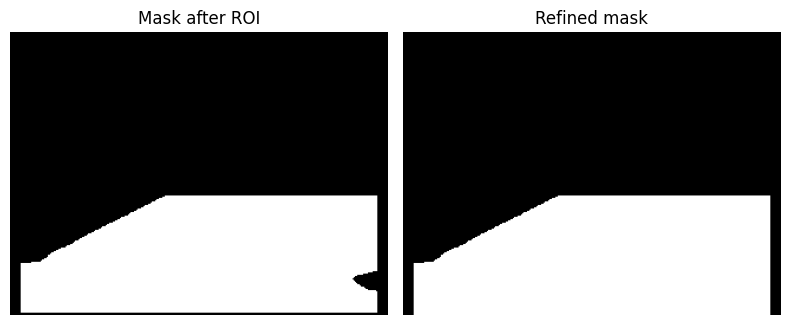

In [5]:
import numpy as np
import cv2

def refine_mask01(mask01: np.ndarray) -> np.ndarray:
    # Convert mask to uint8 with values 0 or 255
    mask_uint8 = (mask01 * 255).astype(np.uint8)

    # Apply morphological closing to fill small gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 25))
    closed = cv2.morphologyEx(mask_uint8, cv2.MORPH_CLOSE, kernel)

    # Remove small connected components (keep the largest two)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed)
    areas = stats[1:, cv2.CC_STAT_AREA]
    sorted_idx = areas.argsort()[::-1]
    mask_filtered = np.zeros_like(closed)
    for i in sorted_idx[:2]:
        comp_label = i + 1
        mask_filtered[labels == comp_label] = 255
    refined = (mask_filtered > 0).astype(np.uint8)
    return refined

# Apply refine_mask01 to the ROI mask
refined_mask = refine_mask01(mask_roi)

# Display the refined maska
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.title('Mask after ROI')
plt.imshow(mask_roi, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Refined mask')
plt.imshow(refined_mask, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

### 4. Saving the Image

In [ ]:
import os
import cv2
import time

# mask_refined: the final refined mask (binary 0/1 or 0/255)

# 1) Create the folder result_refine if it does not already exist
save_dir = "result_refine"
os.makedirs(save_dir, exist_ok=True)

# 2) Generate an output filename using a timestamp to avoid overwriting
filename = f"refined_{int(time.time())}.png"
save_path = os.path.join(save_dir, filename)

# 3) Convert the mask to 0–255 format before saving
mask_to_save = (refined_mask * 255).astype("uint8")

# 4) Save the image
cv2.imwrite(save_path, mask_to_save)

print("Refined mask has been saved at:", save_path)


### Summary
In this lab, you implemented two important pre-processing steps for lane segmentation masks: applying a region of interest and refining the mask with morphological operations. A clean mask is critical for accurate geometry estimation and reliable lane following.